In [ ]:
## Preprocessing

In [3]:
import pandas as pd
import networkx as nx
import localization
import separation
import proximity
import seaborn as sns
import matplotlib.pylab as plt

disease_gene_data = pd.read_csv('datasets/disease_gene.tsv', sep='\t')
drug_target_data = pd.read_csv('datasets/drug_target.csv')

print("\nBeginning preprocessing:")
print(disease_gene_data.head())
print("Diseases number: ",len(disease_gene_data))
print("------------------------------------------------")
print(drug_target_data.head())
print("Drugs number: ",len(drug_target_data))

# Filter disease_gene associations, so that we only focus on those disease types that are not “group” or “phenotype”,
disease_gene_data = disease_gene_data[
    (disease_gene_data['diseaseType'] != 'group') &
    (disease_gene_data['diseaseType'] != 'phenotype')]

# Lower disease names and use these names to identify diseases.
disease_gene_data = disease_gene_data[disease_gene_data.diseaseType == 'disease'][['geneSymbol', 'diseaseName']].drop_duplicates()
disease_gene_data['diseaseName'] = disease_gene_data['diseaseName'].str.lower()

# Filter disease_gene associations, so that we only focus on those disease that have at least 10 associated genes.
gene_count_per_disease = (disease_gene_data.groupby('diseaseName')
                                             .agg('count')
                                             .sort_values(by='geneSymbol')
                                             .reset_index()
                                             .rename(columns={'geneSymbol':'count_genes'}))

disease_gene_data = disease_gene_data.merge(gene_count_per_disease, 
                         on='diseaseName', 
                         how='inner')

disease_gene_data = disease_gene_data[(disease_gene_data['count_genes'] >= 10)]

# Filter drug targets so that they are related to Humans.
# Use drug names to identify drugs
drug_target_data = drug_target_data[drug_target_data.organism=='Humans'][['Gene_Target','Name']].drop_duplicates()

print("\nEnd preprocessing:")
print(disease_gene_data.head())
print("Diseases number: ",len(disease_gene_data))
print("------------------------------------------------")
print(drug_target_data.head())
print("Drugs number: ",len(drug_target_data))


Beginning preprocessing:
   geneId geneSymbol    DSI    DPI diseaseId               diseaseName  \
0       1       A1BG  0.700  0.538  C0019209              Hepatomegaly   
1       1       A1BG  0.700  0.538  C0036341             Schizophrenia   
2       2        A2M  0.529  0.769  C0002395       Alzheimer's Disease   
3       2        A2M  0.529  0.769  C0007102  Malignant tumor of colon   
4       2        A2M  0.529  0.769  C0009375         Colonic Neoplasms   

  diseaseType diseaseClass               diseaseSemanticType  score     EI  \
0   phenotype      C23;C06                           Finding   0.30  1.000   
1     disease          F03  Mental or Behavioral Dysfunction   0.30  1.000   
2     disease      C10;F03               Disease or Syndrome   0.50  0.769   
3     disease      C06;C04                Neoplastic Process   0.31  1.000   
4       group      C06;C04                Neoplastic Process   0.30  1.000   

   YearInitial  YearFinal  NofPmids  NofSnps     source  
0 

## Network medicine

In [27]:
ppi = pd.read_csv('datasets/ppi.csv')

# drop duplicates
ppi = (ppi[['Symbol_A','Symbol_B']]
       .drop_duplicates()
       .dropna())

gppi = nx.from_pandas_edgelist(ppi, 'Symbol_A', 'Symbol_B')

# Removing self loops
sl = nx.selfloop_edges(gppi)
gppi.remove_edges_from(sl)

In [28]:
def get_disease_module_info(dis_name, gda, ppi):
    
    d = gda[gda.diseaseName == dis_name]
    genes = list(d.geneSymbol.unique())
    genes_in_ppi = [n for n in gppi.nodes if n in genes]
    genes_in_lcc = localization.get_lcc(ppi, genes_in_ppi)
    
    print('Number of disease genes: ',len(genes))
    print('Number of disease genes in the PPI: ',len(genes_in_ppi))
    print('Number of disease genes in the LCC: ',len(genes_in_lcc))
    
    return genes, genes_in_ppi, genes_in_lcc

In [29]:
dermatitis = get_disease_module_info('dermatitis', disease_gene_data, gppi)

Number of disease genes:  16
Number of disease genes in the PPI:  16
Number of disease genes in the LCC:  7


### Disease separation
Let's compare Dermatitis and Psoriasis

In [30]:
psoriasis = get_disease_module_info('psoriasis', disease_gene_data, gppi)
separation_dermatitis_psoriasis = separation.get_separation(gppi, psoriasis[2], dermatitis[2])
print("separation_dermatitis_psoriasis : ",separation_dermatitis_psoriasis)

Number of disease genes:  57
Number of disease genes in the PPI:  57
Number of disease genes in the LCC:  30
separation_dermatitis_psoriasis :  1.6216216216216217


Let's compare Dermatitis and Skizophrenia

In [31]:
schizophrenia = get_disease_module_info('schizophrenia', disease_gene_data, gppi)
separation_dermatitis_schizophrenia = separation.get_separation(gppi, schizophrenia[2], dermatitis[2])
print("separation_dermatitis_schizophrenia : ",separation_dermatitis_schizophrenia)

Number of disease genes:  883
Number of disease genes in the PPI:  846
Number of disease genes in the LCC:  683
separation_dermatitis_schizophrenia :  1.8753623188405797


### Disease - drug proximity

In [32]:
def plot_proximity(G, genes, targets, sim):
    
    prox_dict = proximity.get_proximity(G, genes, targets, sim)
    
    prox_obs = prox_dict['proximity']
    random_prox = prox_dict['proximity_list']

    print('Proximity observed: ',prox_obs)
    print('\nMean: ',prox_dict['mean'])
    print('Std: ',prox_dict['std'])
    print('z-score: ',prox_dict['z_score'])
    print('p-value: ',prox_dict['p_value'])


    fig, axs = plt.subplots()
    sns.histplot(data=random_prox,
                 bins=10)
    plt.axvline(prox_obs, color='r')
    plt.xlabel('Proximity value')
    plt.ylabel('Count iterations')
    plt.tight_layout()
    plt.show()

Masoprocol
	Targets:  ['ALOX5' 'SHBG']
Proximity observed:  2.142857142857143

Mean:  2.203285714285714
Std:  0.1341694785694266
z-score:  -0.4503898507535901
p-value:  0.6524293618228925


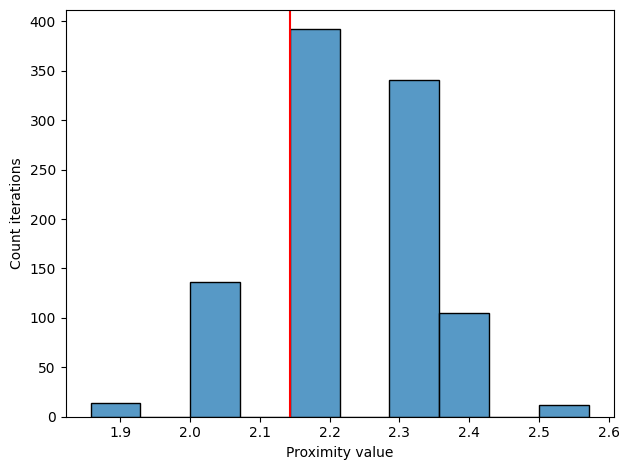

In [36]:
le_t = drug_target_data[drug_target_data.Name == 'Masoprocol'].Gene_Target.unique()
print('Masoprocol')
print('\tTargets: ',le_t)

plot_proximity(gppi, 
               set(dermatitis[2]), 
               set(le_t), 
               1000)